In [24]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import sys
import warnings
import h5py

import numpy as np
import pandas as pd

import datetime

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_100-perturbed"
# run_name = "cluster_cooling_100-small_steps"
# run_name = "cluster_cooling_mhd_100"
# run_name = "cluster_cooling_133"
# run_name = "cluster_cooling_200"
# run_name = "cluster_cooling_200-perturbed"
# run_name = "cluster_cooling_200-quantify_distributions"
# run_name = "cluster_cooling_200-small_steps"
# run_name = "cluster_cooling_200-small_steps-early"
# run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
# run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_mhd_large_200-small_steps"
# run_name = "cluster_cooling_mhd_large_200-small_steps-early"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_400-perturbed"
# run_name = "cluster_cooling_400-small_steps"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
save_plots = True

# Update / Load Database

In [4]:
add_simulation(run_name, verbose=True)

df = open_as_DataFrame(run_name)
df.tail()

adding:  ../runs/cluster_cooling_100/outputs/snapshot_000.hdf5
Snapshot #0 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_001.hdf5
Snapshot #1 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_002.hdf5
Snapshot #2 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_003.hdf5
Snapshot #3 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_004.hdf5
Snapshot #4 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_005.hdf5
Snapshot #5 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_006.hdf5
Snapshot #6 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_007.hdf5
Snapshot #7 already found for run: cluster_cooling_100
adding:  ../runs/cluster_cooling_100/outputs/snapshot_00

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
109,109,37.924087,4.609220e+49,4.864404e+50,0.0,7.097510e+06,4.266559e+44,cluster_cooling_100
110,110,38.442815,4.576272e+49,4.863767e+50,0.0,7.097510e+06,4.256315e+44,cluster_cooling_100
111,111,38.961543,4.545406e+49,4.864755e+50,0.0,7.097510e+06,4.246495e+44,cluster_cooling_100
112,112,39.480272,4.516253e+49,4.865820e+50,0.0,7.097510e+06,4.237081e+44,cluster_cooling_100
113,113,39.999000,4.486760e+49,4.866277e+50,0.0,7.097510e+06,4.228116e+44,cluster_cooling_100


# Overview

In [5]:
ts = load_snapshots(outputs_dir)
snapshot_filenames = get_snapshot_filenames(outputs_dir)

snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                for i,filename in enumerate(snapshot_filenames) }

uncompressed_snapshot_numbers = sorted(list(snapshot_number_to_index_map.keys()))

times_snapshots = df.time

print("Loaded {} uncompressed snapshots".format(len(ts)))

ds = load_ds_from_ts(ts, 0)
rho_0 = None

# if rho_0 is None:
#     rho_0 = load_ds_from_ts(ts, 0).all_data()["all","density"].mean()

Loaded 11 uncompressed snapshots


yt : [INFO     ] 2018-08-25 16:26:46,727 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-25 16:26:46,791 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-08-25 16:26:46,793 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-25 16:26:46,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-25 16:26:46,799 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-25 16:26:46,802 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-25 16:26:46,812 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-08-25 16:26:47,844 Identified 2.955e+05 octs
/pfs/home/egentry/anaconda3/envs/py36/lib/python3.6/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[

In [6]:
times_snapshots

0       0.000000
1       0.001000
2       0.127017
3       0.253034
4       0.379051
5       0.505068
6       0.631085
7       0.633085
8       1.014899
9       1.396712
10      1.778526
11      2.160339
12      2.542153
13      2.544153
14      2.663841
15      2.783530
16      2.903218
17      3.022906
18      3.142595
19      3.144595
20      3.289131
21      3.433668
22      3.578205
23      3.722742
24      3.867279
25      3.867279
26      3.869279
27      4.387625
28      4.905972
29      5.424318
         ...    
84     27.160264
85     27.162264
86     27.446806
87     27.731349
88     28.015891
89     28.300434
90     28.584976
91     28.586976
92     29.105704
93     29.624433
94     30.143161
95     30.661890
96     31.180618
97     31.699346
98     32.218075
99     32.736803
100    33.255531
101    33.774260
102    34.292988
103    34.811716
104    35.330445
105    35.849173
106    36.367901
107    36.886630
108    37.405358
109    37.924087
110    38.442815
111    38.9615

In [7]:
print( "Length unit: ",   ds.length_unit)
print( "Time unit: ",     ds.time_unit)
print( "Mass unit: ",     ds.mass_unit)
print( "Velocity unit: ", ds.velocity_unit)

Length unit:  0.001000000000163616 kpc
Time unit:  31557600000000.0 s
Mass unit:  1.0000299511482191 Msun
Velocity unit:  97779.22216731282 cm/s


# What fields do I have access to?

In [8]:
ds.add_particle_filter("overdense")

True

In [9]:
dd = ds.all_data()

In [10]:
ds.field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Velocities'),
 ('all', 'Coordinates'),
 ('all', 'Density'),
 ('all', 'ElectronAbundance'),
 ('all', 'InternalEnergy'),
 ('all', 'Masses'),
 ('all', 'Metallicity'),
 ('all', 'NeutralHydrogenAbundance'),
 ('all', 'ParticleChildIDsNumber'),
 ('all', 'ParticleIDGenerationNumber'),
 ('all', 'ParticleIDs'),
 ('all', 'SmoothingLength'),
 ('all', 'Velocities')]

In [11]:
ds.derived_field_list

[('PartType0', 'Coordinates'),
 ('PartType0', 'Density'),
 ('PartType0', 'ElectronAbundance'),
 ('PartType0', 'H_nuclei_density'),
 ('PartType0', 'He_nuclei_density'),
 ('PartType0', 'InternalEnergy'),
 ('PartType0', 'Masses'),
 ('PartType0', 'Metallicity'),
 ('PartType0', 'NeutralHydrogenAbundance'),
 ('PartType0', 'ParticleChildIDsNumber'),
 ('PartType0', 'ParticleIDGenerationNumber'),
 ('PartType0', 'ParticleIDs'),
 ('PartType0', 'SmoothingLength'),
 ('PartType0', 'Temperature'),
 ('PartType0', 'Velocities'),
 ('PartType0', 'density'),
 ('PartType0', 'mesh_id'),
 ('PartType0', 'metallicity'),
 ('PartType0', 'particle_angular_momentum'),
 ('PartType0', 'particle_angular_momentum_magnitude'),
 ('PartType0', 'particle_angular_momentum_x'),
 ('PartType0', 'particle_angular_momentum_y'),
 ('PartType0', 'particle_angular_momentum_z'),
 ('PartType0', 'particle_cylindrical_velocity_theta'),
 ('PartType0', 'particle_cylindrical_velocity_z'),
 ('PartType0', 'particle_index'),
 ('PartType0', '

# Extract R_shock, V_shock

In [12]:
ds = load_ds_from_ts(ts, 5)
ds.add_particle_filter("overdense")
dd = ds.all_data()

yt : [INFO     ] 2018-08-12 21:36:30,364 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 21:36:30,414 Parameters: current_time              = 0.505068364443998
yt : [INFO     ] 2018-08-12 21:36:30,416 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 21:36:30,419 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 21:36:30,422 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 21:36:30,424 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 21:36:30,435 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 21:36:35,496 Identified 2.952e+05 octs


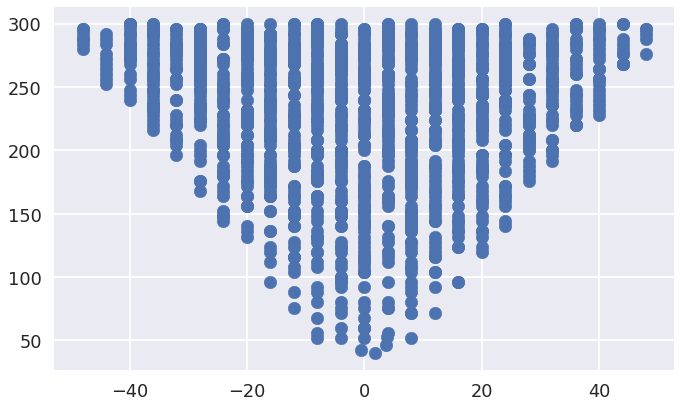

In [57]:
plt.scatter(coords_full[:,0][mask],
         coords_full[:,1][mask])

In [12]:
def get_shock_thickness_and_radius(run_name, i_snapshot=5):
    
    run_dir = os.path.join(os.path.pardir, "runs", run_name)
    outputs_dir = os.path.join(run_dir, "outputs")    
    ts = load_snapshots(outputs_dir)

    snapshot_filenames = get_snapshot_filenames(outputs_dir)

    snapshot_number_to_index_map = {snapshot_filename_to_number(filename) : i
                                    for i,filename in enumerate(snapshot_filenames) }
    
    ds = load_ds_from_ts(ts, snapshot_number_to_index_map[i_snapshot])
    ds.add_particle_filter("overdense")
    dd = ds.all_data()
    
    spacing_degrees = 20
    num_sightlines = int(360 / spacing_degrees)

    cos_tolerance = np.cos(spacing_degrees/2 * (np.pi/180))

    thicknesses = [None]*num_sightlines
    radii = [None]*num_sightlines
    for i in range(num_sightlines):
        angle = spacing_degrees * i * (np.pi/180)
        unit_vector = np.array([np.sin(angle), np.cos(angle), 0])

        coords_full = dd["overdense", "Coordinates"] - ds.domain_center
        coords_norm = (coords_full**2).sum(axis=1)**.5
        coords_unit = coords_full / coords_norm.reshape((-1, 1))

        cosine_similarity = np.dot(coords_unit, unit_vector)
        mask = cosine_similarity > cos_tolerance

        thicknesses[i] = float(np.std(dd["overdense", "particle_position_spherical_radius"][mask]).to("pc").value)
        radii[i] = float(np.mean(dd["overdense", "particle_position_spherical_radius"][mask]).to("pc").value)

    return thicknesses, radii


In [17]:
a = 1 * yt.units.pc
a.to("pc").value

array(1.)

In [14]:
%%time
thicknesses, radii = get_shock_thickness_and_radius("cluster_cooling_100")

yt : [INFO     ] 2018-08-12 21:36:40,166 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 21:36:40,215 Parameters: current_time              = 0.505068364443998
yt : [INFO     ] 2018-08-12 21:36:40,217 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 21:36:40,220 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 21:36:40,223 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 21:36:40,225 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 21:36:40,236 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 21:36:41,099 Identified 2.952e+05 octs


CPU times: user 6.71 s, sys: 20.2 s, total: 27 s
Wall time: 25.1 s


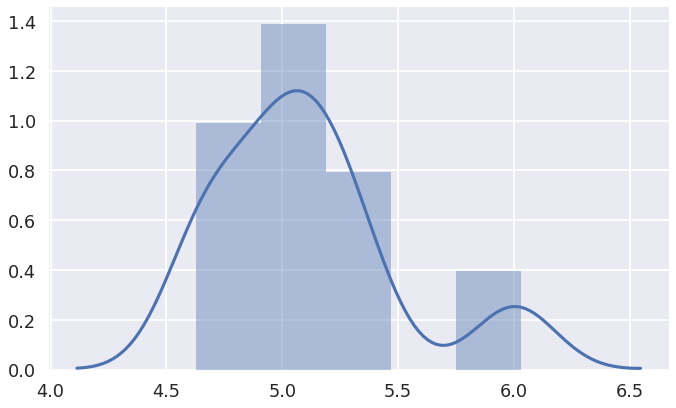

In [15]:
sns.distplot(thicknesses)

In [16]:
thicknesses_map = {}
radii_map = {}

run_names = [
    "cluster_cooling_100", 
    "cluster_cooling_200", 
    "cluster_cooling_400",
]

start_time = datetime.datetime.now()
for run_name in run_names:
    thicknesses_map[run_name], radii_map[run_name] = get_shock_thickness_and_radius(run_name)
    print("done: ", run_name)
    current_time = datetime.datetime.now()
    print("took {} seconds so far".format((current_time - start_time).seconds))
    sys.stdout.flush()

yt : [INFO     ] 2018-08-12 21:37:08,732 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 21:37:08,778 Parameters: current_time              = 0.505068364443998
yt : [INFO     ] 2018-08-12 21:37:08,780 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 21:37:08,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 21:37:08,785 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 21:37:08,788 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 21:37:08,798 Allocating for 3.375e+06 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 21:37:09,622 Identified 2.952e+05 octs


done:  cluster_cooling_100
took 7 seconds so far


yt : [INFO     ] 2018-08-12 21:37:15,824 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 21:37:15,855 Parameters: current_time              = 0.505068364443998
yt : [INFO     ] 2018-08-12 21:37:15,858 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 21:37:15,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 21:37:15,861 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 21:37:15,862 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 21:37:15,867 Allocating for 2.700e+07 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 21:37:27,598 Identified 2.362e+06 octs


done:  cluster_cooling_200
took 112 seconds so far


yt : [INFO     ] 2018-08-12 21:39:01,130 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2018-08-12 21:39:01,150 Parameters: current_time              = 0.505068364443998
yt : [INFO     ] 2018-08-12 21:39:01,151 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2018-08-12 21:39:01,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-08-12 21:39:01,153 Parameters: domain_right_edge         = [600. 600. 600.]
yt : [INFO     ] 2018-08-12 21:39:01,155 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2018-08-12 21:39:01,162 Allocating for 2.160e+08 particles (index particle type 'all')
yt : [INFO     ] 2018-08-12 21:42:08,651 Identified 1.890e+07 octs


done:  cluster_cooling_400
took 1131 seconds so far


In [13]:
# thicknesses_map = {'cluster_cooling_100': [5.008489692138171 * pc,
#   4.791514818549523 * pc,
#   5.210845655149203 * pc,
#   4.668780354858317 * pc,
#   4.628787779873119 * pc,
#   5.228010346803027 * pc,
#   5.364243759322976 * pc,
#   5.133371661894269 * pc,
#   4.740905015361694 * pc,
#   6.031015483642938 * pc,
#   4.960488209325502 * pc,
#   5.976998531713043 * pc,
#   5.3370112269365695 * pc,
#   5.160560207229715 * pc,
#   4.962288260655043 * pc,
#   4.628395917664643 * pc,
#   5.06739561747607 * pc,
#   4.97395736713257 * pc],
#  'cluster_cooling_200': [2.771883374562317 * pc,
#   2.6176082046204163 * pc,
#   2.8545445505916263 * pc,
#   3.2818893866395658 * pc,
#   3.2457370753118613 * pc,
#   3.850523581995146 * pc,
#   2.3837013841793584 * pc,
#   3.0681458463499784 * pc,
#   3.6431909992401197 * pc,
#   3.8645727023091845 * pc,
#   2.8470962899976047 * pc,
#   2.7272510911969228 * pc,
#   2.689014773486777 * pc,
#   2.5755053105762133 * pc,
#   2.7672678860031295 * pc,
#   2.984100102817971 * pc,
#   3.2636492811166944 * pc,
#   2.979130374247349 * pc],
#  'cluster_cooling_400': [1.9642746777157685 * pc,
#   1.6974920501673911 * pc,
#   1.8984161604416891 * pc,
#   2.071233945537992 * pc,
#   2.2137296259821184 * pc,
#   1.9524062888460532 * pc,
#   1.9653839496112715 * pc,
#   1.7602064579295016 * pc,
#   1.8604125814933796 * pc,
#   1.8611475068428713 * pc,
#   1.6425834116584206 * pc,
#   2.041638384934669 * pc,
#   1.961776085382136 * pc,
#   1.8040628161180268 * pc,
#   2.87620222955414 * pc,
#   2.940073095723431 * pc,
#   1.9489224967165177 * pc,
#   2.454518044007954 * pc]}

In [20]:
thicknesses_map

{'cluster_cooling_100': [1.5454584360040268e+19,
  1.47850698568661e+19,
  1.6078989618579616e+19,
  1.4406350873780746e+19,
  1.4282946681723775e+19,
  1.6131954322808615e+19,
  1.6552326709668194e+19,
  1.5839929854446123e+19,
  1.4628904321766949e+19,
  1.8609769271358525e+19,
  1.5306467260648032e+19,
  1.8443090373769257e+19,
  1.6468295894996881e+19,
  1.5923824939260416e+19,
  1.531202163868109e+19,
  1.4281737521292059e+19,
  1.5636349053271003e+19,
  1.5348028738934546e+19],
 'cluster_cooling_200': [8.553138387328567e+18,
  8.077094954061804e+18,
  8.80820412505992e+18,
  1.012685250520882e+19,
  1.0015298128626698e+19,
  1.1881474293873168e+19,
  7.355333922074558e+18,
  9.46730885475381e+18,
  1.1241712791358292e+19,
  1.1924825349465532e+19,
  8.785221194324022e+18,
  8.415417551138279e+18,
  8.297432602782225e+18,
  7.947178997794718e+18,
  8.538896477753964e+18,
  9.207970788119353e+18,
  1.0070569420513298e+19,
  9.192635808083009e+18],
 'cluster_cooling_400': [6.0611183

In [18]:
# radii_map = {'cluster_cooling_100': [48.472913893792814 * pc,
#   46.10357318169029 * pc,
#   47.06347431648544 * pc,
#   42.579738849318886 * pc,
#   43.9907695540688 * pc,
#   46.40221960578741 * pc,
#   44.119210458704316 * pc,
#   47.687090789363225 * pc,
#   47.55620898018435 * pc,
#   50.0159176384206 * pc,
#   47.36359520966303 * pc,
#   49.44372343013022 * pc,
#   47.82452710931455 * pc,
#   49.23842756988566 * pc,
#   46.065881269299695 * pc,
#   44.961425690333314 * pc,
#   46.95988602518545 * pc,
#   44.26039941400705 * pc],
#  'cluster_cooling_200': [43.287852911420124 * pc,
#   43.24491310052384 * pc,
#   41.940612857474726 * pc,
#   43.90600403192576 * pc,
#   44.69971917473677 * pc,
#   44.46646152728868 * pc,
#   43.179937950882824 * pc,
#   43.77201005942049 * pc,
#   45.49564615900104 * pc,
#   44.23470864346315 * pc,
#   44.92230424962297 * pc,
#   43.845643774995715 * pc,
#   44.100511642018006 * pc,
#   44.02963573365741 * pc,
#   43.14596700658516 * pc,
#   44.271025399700555 * pc,
#   44.10959159279782 * pc,
#   43.83328851063844 * pc],
#  'cluster_cooling_400': [43.82402165294304 * pc,
#   43.27003039194585 * pc,
#   42.88600212429869 * pc,
#   42.94202347504095 * pc,
#   42.93480715706272 * pc,
#   43.07148523548787 * pc,
#   42.59286992705439 * pc,
#   43.33996078223996 * pc,
#   43.1157790447827 * pc,
#   43.53470974602405 * pc,
#   43.369750713411094 * pc,
#   44.363043927716745 * pc,
#   43.78450597007935 * pc,
#   43.73847793467334 * pc,
#   42.1994323480893 * pc,
#   43.0387134900475 * pc,
#   44.31117652009728 * pc,
#   43.877677922616364 * pc]}

In [21]:
radii_map

{'cluster_cooling_100': [1.49571783710466e+20,
  1.4226076219227375e+20,
  1.4522270760433607e+20,
  1.3138734559207091e+20,
  1.3574133140447956e+20,
  1.4318228876789558e+20,
  1.3613765862445675e+20,
  1.4714698697412869e+20,
  1.4674312790972357e+20,
  1.5433299577338393e+20,
  1.4614878391614407e+20,
  1.525673889326169e+20,
  1.4757107114548185e+20,
  1.5193391209909227e+20,
  1.4214445710320746e+20,
  1.3873646328346454e+20,
  1.4490306753616919e+20,
  1.3657332221858516e+20],
 'cluster_cooling_200': [1.3357235727861837e+20,
  1.3343985886678326e+20,
  1.294152088473044e+20,
  1.3547977233312144e+20,
  1.379289213553644e+20,
  1.3720916346192804e+20,
  1.332393665041835e+20,
  1.3506631013611019e+20,
  1.4038489540719344e+20,
  1.3649404878386723e+20,
  1.3861574713090993e+20,
  1.3529352004150079e+20,
  1.3607996010500784e+20,
  1.3586125990351341e+20,
  1.3313454312294294e+20,
  1.366061105844206e+20,
  1.3610797790556992e+20,
  1.3525539567926044e+20],
 'cluster_cooling_400':

In [36]:
run_name_map = {
    "cluster_cooling_100": r"3D_40_HD",
    "cluster_cooling_200": r"3D_20_HD",
    "cluster_cooling_400": r"3D_10_HD",
}

(1, 7)

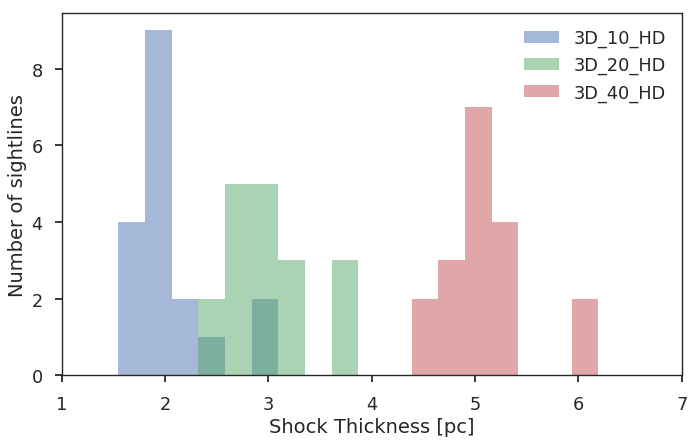

In [40]:
bins = np.linspace(0, 8, num=32)
for run_name in sorted(thicknesses_map, reverse=True):
    plt.hist(np.array(thicknesses_map[run_name])/pc, 
             label=run_name_map[run_name],
             bins=bins,
             alpha=.5,
            )
    
plt.legend(loc="best")

plt.xlabel("Shock Thickness [pc]")
plt.ylabel("Number of sightlines")

plt.xlim(left=1, right=7)

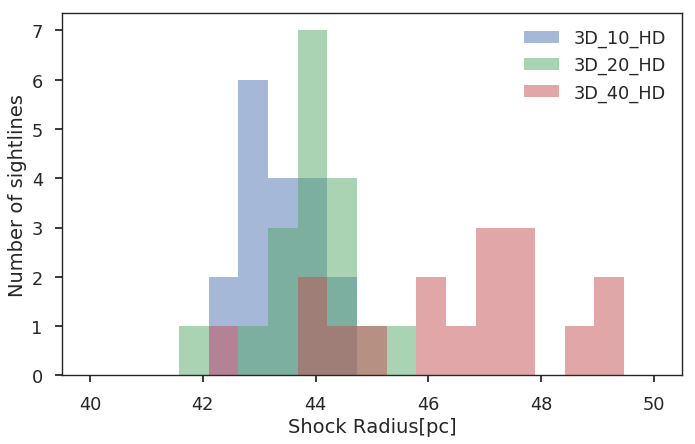

In [46]:
bins = np.linspace(40, 50, num=20)
for run_name in sorted(thicknesses_map, reverse=True):
    plt.hist(np.array(radii_map[run_name])/pc, 
             label=run_name_map[run_name],
             bins=bins,
             alpha=.5,
            )
    
plt.legend(loc="best")

plt.xlabel("Shock Radius[pc]")
plt.ylabel("Number of sightlines")

# plt.xlim(left=1, right=7)